 # PAOO5: High Value Customer Identification (Insiders)

## Planejamento da solução (IoT)

### Input

1. Problema de negocio
    * selecionar os clientes mais valiosos para integrar um programa de fidelizacao.
2. Conjunto de dados
    * Vendas de um e-commerce online, durante o periodo de um ano.

### Output

1. A indicacao das pessoas que farao parte do programa de Insiders
    - Lista: client_id|is_insider


2. Relatorio com as respostas das perguntas de negocio
- Quem sao as pessoas elegiveis para participar do programa insiders ?
    1. **Who are the people eligible to participate in the Insiders program?**
    2. **How many customers will be part of the group?**
    3. **What are the main characteristics of these customers?**
    4. **What percentage of revenue contribution comes from Insiders?**
    5. **What is this group's expected revenue for the coming months?**
    6. **What are the conditions for a person to be eligible for Insiders?**
    7. **What are the conditions for a person to be removed from Insiders?**
    8. **What is the guarantee that the Insiders program is better than the rest of the base?**
    9. **What actions can the marketing team take to increase revenue?**

### Tasks

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0 IMPORTS

In [1]:
# %pip install plotly

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import HTML
import inflection
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn import metrics as m
from plotly import express as px
import umap.umap_ as umap
import re
from sklearn import preprocessing as pp


## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2 Loadind dataset

In [4]:
df_raw=pd.read_csv('/home/tc0019/DS/insiders_cluster/dataset/Ecommerce.csv', encoding='unicode_escape')
df_raw=df_raw.drop( columns = ['Unnamed: 8'], axis=1)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# <font color='red'> 1.0. Descrição dos dados </font>

In [5]:
df1 = df_raw.copy()

## 1.1. Rename columuns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [7]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [10]:
# remova na
df1 = df1.dropna( subset=['description', 'customer_id'] )
print( 'Removed data: {:.2f}'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.25


In [11]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change dtypes

In [12]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributs

In [15]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### <font color='red'> 1.7.1.1. Numerical Attributs - Investigating </font>

1. Quantity negativa ( pode ser devolução )


2. Preço unitário igual a zero ( pode ser promoção? )

### 1.7.2. Categorical Attributs

#### Invoice No

In [16]:
# problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype( int )

# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 8905
Total number of negative quantity: 8905


#### Stock Code

In [17]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

#### Description

In [18]:
df1.head()

# Acão: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


#### Country

In [19]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [20]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.889509
Germany           0.023339
France            0.020871
EIRE              0.018398
Spain             0.006226
Name: country, dtype: float64

In [21]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False).head()

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


# <font color='red'> 2.0. Filtragem de Varivéis </font>

In [22]:
df2 = df1.copy()

In [23]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [24]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'] )]

# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# <font color='red'> 3.0. Feature Engineering </font>

In [25]:
df3 = df2.copy()

## 3.1. Feature Creation

In [26]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [27]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

/home/tc0019/anaconda3/envs/pa05env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


customer_id       0
gross_revenue    27
dtype: int64

In [28]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [29]:
# Frequency
df_freq = df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [30]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [31]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3232.59,56.0,9.0,18.904035
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [32]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

# <font color='red'> 5.0. Data Preparation </font>

In [33]:
df5 = df4.copy()

In [34]:
## Standard Scalaer
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )

In [35]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.377179,2.791504,3.889207,-0.033935
1,13047,0.135378,-0.360996,0.620902,-0.033423
2,12583,0.524388,-0.899714,1.405296,-0.026618
3,13748,-0.120506,0.028079,0.097974,-0.023240
4,15100,-0.128600,2.402430,-0.163491,0.152447


# <font color='red'> 6.0. Feature Selection </font>

In [36]:
df6 = df5.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [37]:
X = df6.drop( columns=['customer_id'] )

In [38]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.377179,2.791504,3.889207,-0.033935
1,0.135378,-0.360996,0.620902,-0.033423
2,0.524388,-0.899714,1.405296,-0.026618
3,-0.120506,0.028079,0.097974,-0.023240
4,-0.128600,2.402430,-0.163491,0.152447


In [39]:
clusters = [2, 3, 4, 5, 6, 7]

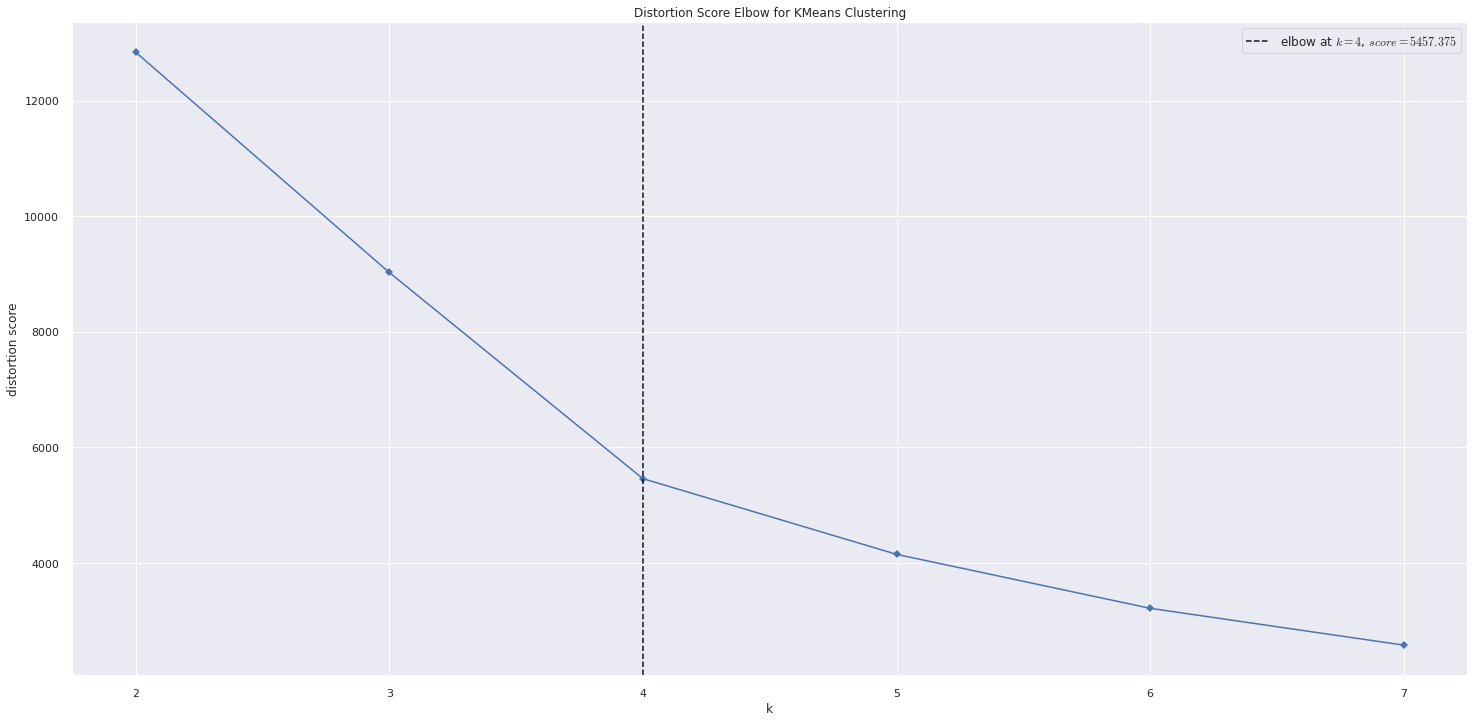

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show()

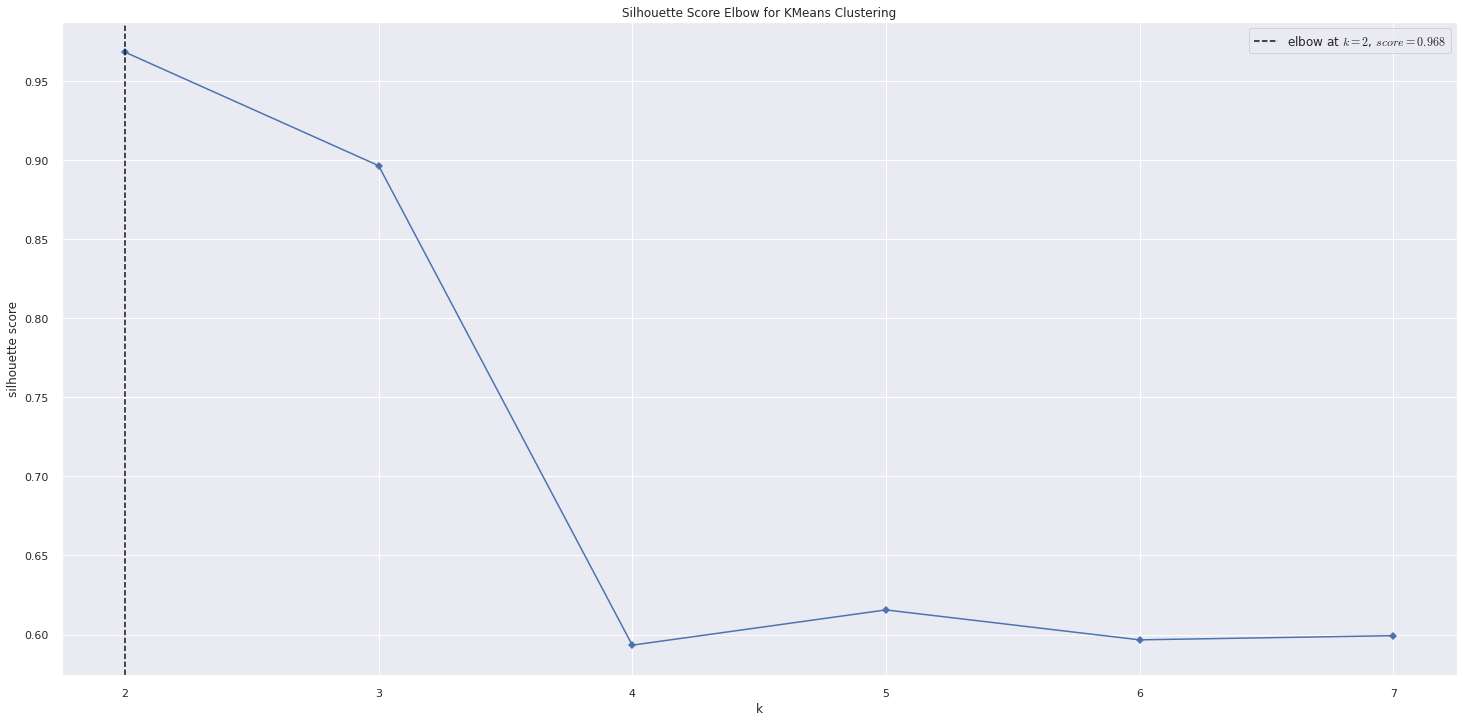

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [41]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

## 7.1. Silhouette Analysis

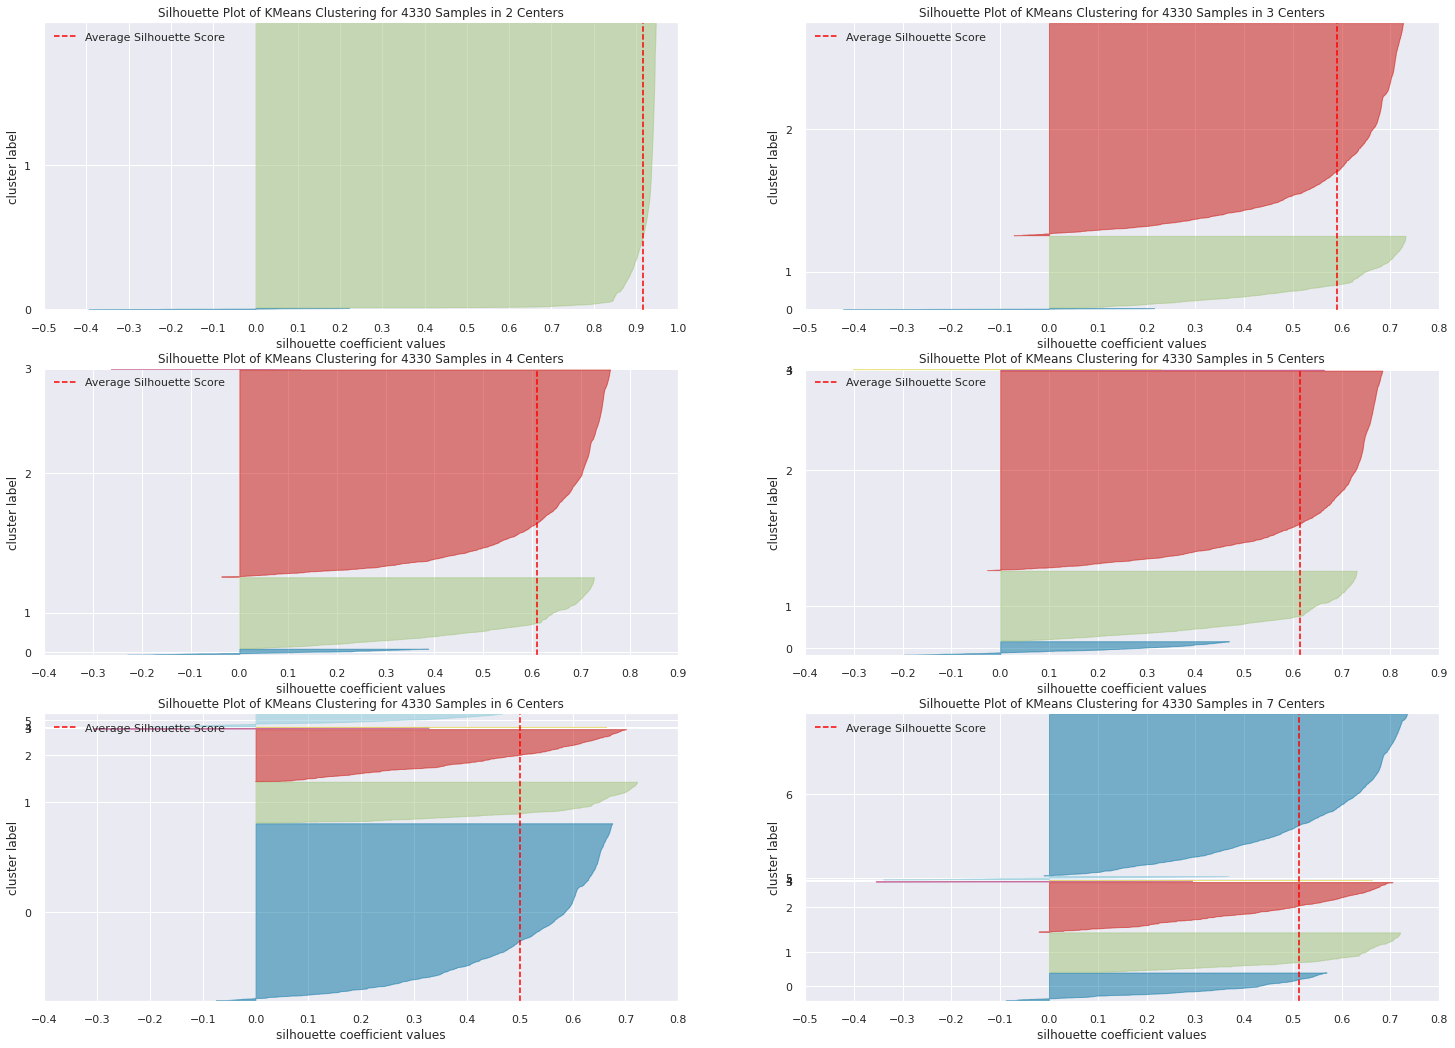

In [42]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# <font color='red'> 8.0. Model Training </font>

## 8.1. K-Means

In [43]:
# model definition
k = 3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

### 8.2. Cluster Validation

In [44]:
from sklearn import metrics as m

In [45]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 9404.844768603238
SS value: 0.5895273303328358


# <font color='red'> 9.0. Cluster Analysis </font>

In [46]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.377179,2.791504,3.889207,-0.033935,1
1,13047,0.135378,-0.360996,0.620902,-0.033423,2
2,12583,0.524388,-0.899714,1.405296,-0.026618,2
3,13748,-0.120506,0.028079,0.097974,-0.023240,2
4,15100,-0.128600,2.402430,-0.163491,0.152447,1


## 9.1. Visualization Inspection

/home/tc0019/anaconda3/envs/pa05env/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


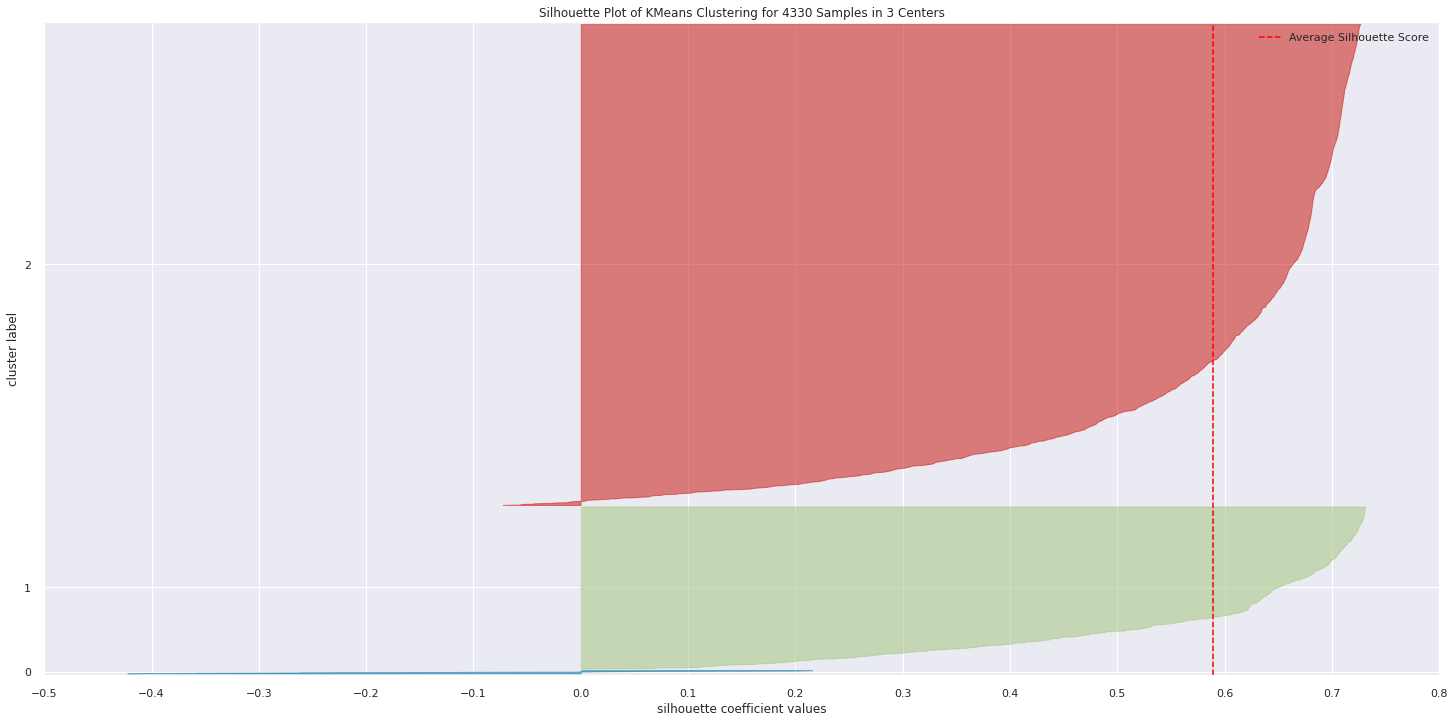

In [47]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

## 9.2. 2d plot

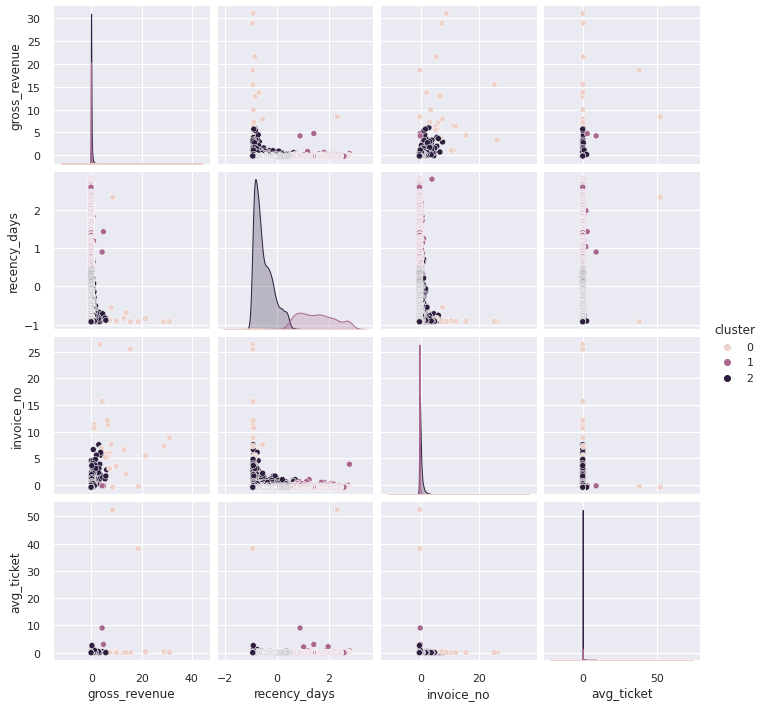

In [48]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster' )

## 9.3. UMAP


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

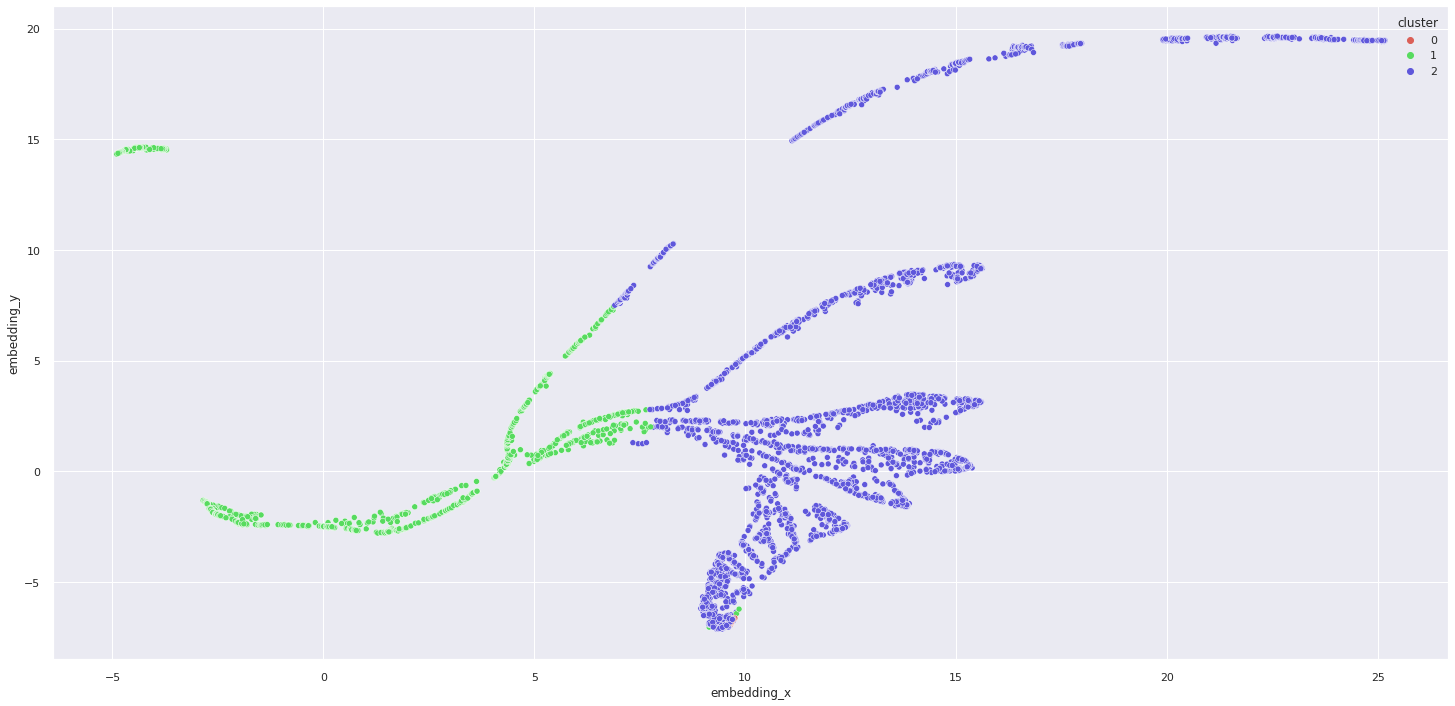

In [49]:
reducer = umap.UMAP( n_neighbors=90, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 9.2. Cluster Profile

In [50]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.377179,2.791504,3.889207,-0.033935,1
1,13047,0.135378,-0.360996,0.620902,-0.033423,2
2,12583,0.524388,-0.899714,1.405296,-0.026618,2
3,13748,-0.120506,0.028079,0.097974,-0.023240,2
4,15100,-0.128600,2.402430,-0.163491,0.152447,1


In [51]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,22,0.508083,10.335282,-0.722409,8.441064,4.189464
1,1,1086,25.080831,-0.164562,1.538959,-0.350320,-0.008675
2,2,3222,74.411085,-0.015103,-0.513785,0.060442,-0.025682


### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 6 (0.14% do customers )
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00 dólares
        
### Cluster 02: 
    - Número de customers: 31 (0.71 do customers )
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52 dólares
        
### Cluster 03: 
    - Número de customers: 4.335 (99% do customers )
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57 dólares

# <font color='red'> 10.0. Deploy To Production </font>

In [52]:
df10=df9.copy()
